# Wheat Disease Detection

### 1.1 Introduction

In this ipython notebook, we would be using various neural network models such as VGG19, Xception and InceptionV3 networks to train our wheat dataset. Implementing these networks using pre-trained weights for "imagenet" is very handy, especially for our computer vision problem of detecting diseases in wheat plants.

In the first few cells, let us import and load the libraries that are important for predicting the changes of a wheat plant to suffer from a disease. Later, preprocessing of the image along with making them compatible with Keras would be done to ensure smooth pipeline. Finally, the networks mentioned above would be used for predicting whether the wheat in an image is healthy or diseased.

### 1.2 Metrics

1. Categorical Cross Entropy
2. Accuracy

### 1.3 Source

The data was downloaded from https://drive.google.com/drive/folders/1OHKtwD1UrdmhqxrpQEeF_X_pqKotxRGD.

It contains 4 folders with the name of the folder being the class. In each folder, there are quite a large number of wheat images and their condition. The following are the 4 classes which we would consider.

1. Leaf Rust
2. Crown and Root Rot
3. Healthy Wheat
4. Wheat Loose Smut

The total number of images that we have taken into consideration are 4500 respectively. We would take about 20 percent of the points for testing using stratified sampling which you could see later in the notebook.

### Table of Contents

&emsp; 1.1 Introduction

&emsp; 1.2 Metrics

&emsp; 1.3 Source




### Importing Libraries

Below are some of the libraries that we are going to use for our deep learning application. These libraries make the task of training convolutional networks easy and straight-forward.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os
import glob

# Path to your Google Drive folder containing zip files
zip_folder = '/content/drive/MyDrive/Images'
extract_base = '/content/dataset'

# Extract all zip files
zip_files = glob.glob(os.path.join(zip_folder, '*.zip'))

for zip_file in zip_files:
    zip_name = os.path.splitext(os.path.basename(zip_file))[0]
    extract_path = os.path.join(extract_base, zip_name)
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("✅ All zip files extracted.")


✅ All zip files extracted.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
import cv2
import os
import pickle
from imutils import paths
from tqdm import tqdm
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import Xception, ResNet152, InceptionV3, NASNetLarge
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline


In [ ]:
LABELS = set(["Crown and Root Rot", "Healthy Wheat", "Leaf Rust", "Wheat Loose Smut"])

### Exploring the images and their paths

In [ ]:
count = 0
for images in paths.list_images('/content/dataset/Crown and Root Rot/'):
    print(images)
    count += 1
    if count == 5:
        break

/content/dataset/Crown and Root Rot/Crown and Root Rot/05531.jpg
/content/dataset/Crown and Root Rot/Crown and Root Rot/05841.jpg
/content/dataset/Crown and Root Rot/Crown and Root Rot/01591.jpg
/content/dataset/Crown and Root Rot/Crown and Root Rot/00441.jpg
/content/dataset/Crown and Root Rot/Crown and Root Rot/07661.jpg


In [ ]:
# import zipfile
# import os

# # Path where all zip files are stored
# zip_dir = "/content/Images"

# # Get all .zip files in that directory
# zip_files = [f for f in os.listdir(zip_dir) if f.endswith(".zip")]

# # Extract each zip file into the same folder
# for zip_file in zip_files:
#     zip_path = os.path.join(zip_dir, zip_file)
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(zip_dir)  # Extracts into /content/Images/
#         print(f"✅ Extracted: {zip_file}")


In [ ]:
image = cv2.imread('/content/dataset/Crown and Root Rot/Crown and Root Rot/00041.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))


Taking a look at the paths where the images are present so that they could be read later using opencv.

In [ ]:
count = 0
for image_path in paths.list_images('/content/dataset/Crown and Root Rot/Crown and Root Rot/'):
    print(image_path)
    count += 1
    if count == 5:
        break

/content/dataset/Crown and Root Rot/Crown and Root Rot/05531.jpg
/content/dataset/Crown and Root Rot/Crown and Root Rot/05841.jpg
/content/dataset/Crown and Root Rot/Crown and Root Rot/01591.jpg
/content/dataset/Crown and Root Rot/Crown and Root Rot/00441.jpg
/content/dataset/Crown and Root Rot/Crown and Root Rot/07661.jpg


We find a way to get the name of the image to be used from paths.

In [ ]:
sample_path = list(paths.list_images('/content/dataset/Crown and Root Rot/'))[0]


In [ ]:
sample_path

'/content/dataset/Crown and Root Rot/Crown and Root Rot/05531.jpg'

Let us now split the path to get our desired result of the image.

In [ ]:
sample_path.split('/')

['',
 'content',
 'dataset',
 'Crown and Root Rot',
 'Crown and Root Rot',
 '05531.jpg']

When taking a look at the directory, we see the following files as shown below.

In [ ]:
os.listdir()

['.config', 'dataset', 'drive', 'sample_data']

In [ ]:
Labels = os.listdir('/content/dataset')


In [ ]:
print(Labels)

['Healthy Wheat', 'Leaf Rust', 'Wheat Loose Smut', 'Crown and Root Rot']


In [ ]:
CROWN_AND_ROOT_ROT_PATH = '/content/dataset/Crown and Root Rot/Crown and Root Rot/'
HEALTHY_AND_WHEAT_PATH = '/content/dataset/Healthy Wheat/Healthy Wheat/'
LEAF_RUST_PATH = '/content/dataset/Leaf Rust/Leaf Rust/'
WHEAT_LOOSE_SMUT_PATH = '/content/dataset/Wheat Loose Smut/Wheat Loose Smut/'


In [ ]:
data = []
labels = []
for image_path in tqdm(paths.list_images(CROWN_AND_ROOT_ROT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)

    label = image_path.split('/')[-2]

    labels.append(label)

for image_path in tqdm(paths.list_images(HEALTHY_AND_WHEAT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)

    label = image_path.split('/')[-2]

    labels.append(label)

for image_path in tqdm(paths.list_images(LEAF_RUST_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)

    label = image_path.split('/')[-2]

    labels.append(label)

for image_path in tqdm(paths.list_images(WHEAT_LOOSE_SMUT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)

    label = image_path.split('/')[-2]

    labels.append(label)



1021it [00:05, 186.37it/s]
1146it [00:17, 65.63it/s]
669it [00:38, 17.34it/s]
930it [00:03, 289.75it/s]


In [ ]:
labels[-1]

'Wheat Loose Smut'

In [ ]:
print(f"Total images in dataset: {len(data)}")

Total images in dataset: 3766


In [ ]:
def count_images(path):
    return len(list(paths.list_images(path)))

total = (
    count_images(CROWN_AND_ROOT_ROT_PATH)
    + count_images(HEALTHY_AND_WHEAT_PATH)
    + count_images(LEAF_RUST_PATH)
    + count_images(WHEAT_LOOSE_SMUT_PATH)
)
print(f"Total images: {total}")

Total images: 3766


# Transfer Learning

Transfer learning is a method in deep learning where a model that is developed for a particular task is reused as the starting point for our model so that we get it for our use cases.

In the below cells, transfer learning is applied which ensures that models are not trained from the start. Instead only the last few layers for our application are trained. This leads to a good reduction in the time taken to train them. Furthermore, this leads to a good improvement in the accuracy of the model as state-of-the-art models are taken for training the models.

## VGG19 Network

VGG19 nework trained on imagenet weights is taken as our base model. In addition to this network, we add more layers so that the final model is used for our task of detecting and identifying wheat diseases.

In [ ]:
headmodel = VGG19(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (224, 224, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(4, activation = 'softmax')(model)


final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
opt = Adam(learning_rate=1e-3)
final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [ ]:
data = np.array(data)
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [ ]:
labels[0]

array([1, 0, 0, 0])

In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(data, labels, test_size = 0.2,
                                                    stratify = labels, random_state = 101)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.15,
    fill_mode="nearest"  # Add this to fill gaps from transformations
)


In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=32,shuffle=True)

In [ ]:
len(X_train)

3012

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15874934637090532290
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15558915060098002560
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
early_stop = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=8
)
fitted_model = final_model.fit(
                         train_generator,
                         steps_per_epoch=len(X_train),
                         validation_data = (X_cv, y_cv),
                         epochs = 50,
                         callbacks=[early_stop, reduce_lr])

Epoch 1/50
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - accuracy: 0.6335 - loss: 1.6353 - val_accuracy: 0.7586 - val_loss: 0.8080 - learning_rate: 0.0010
Epoch 2/50
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.7789 - loss: 0.6779 - val_accuracy: 0.7560 - val_loss: 0.6988 - learning_rate: 0.0010
Epoch 3/50
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.8140 - loss: 0.5218 - val_accuracy: 0.8276 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 4/50
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.8426 - loss: 0.4318 - val_accuracy: 0.8263 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 5/50
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.8591 - loss: 0.3816 - val_accuracy: 0.8462 - val_loss: 0.4615 - learning_rate: 0.0010
Epoch 6/50
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - accuracy: 0.8800 - loss: 0.3455 - val_accuracy: 0.8594 - val_loss: 0.3966 - learning_rate: 0.0010
Epoch 7/50
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accura

12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


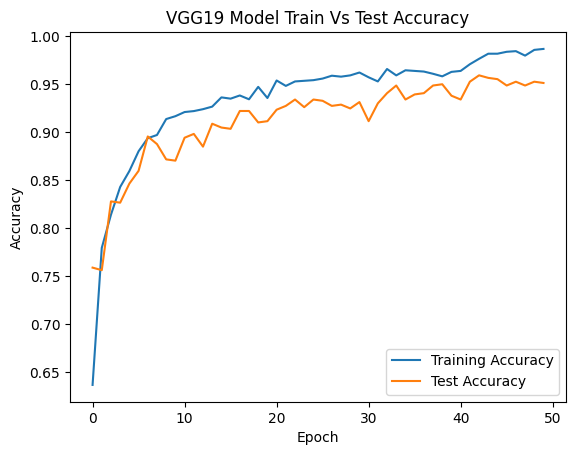

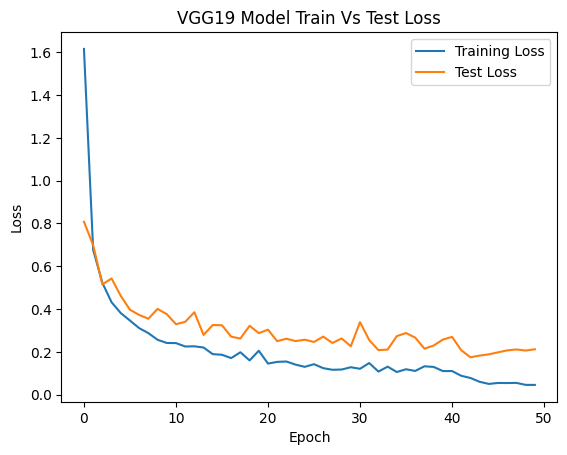

<Figure size 640x480 with 0 Axes>

In [ ]:
predictions = final_model.predict(X_cv, batch_size = 64)
N = len(fitted_model.history['accuracy'])
plt.plot(np.arange(0, N), fitted_model.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.arange(0, N), fitted_model.history['val_accuracy'], label = "Test Accuracy")
plt.title('VGG19 Model Train Vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.show()
plt.savefig(r"C:\Users\akash\Desktop\VG19\VGG19_accuracy_plots1.png")

plt.plot(fitted_model.history['loss'], label = "Training Loss")
plt.plot(fitted_model.history['val_loss'], label = "Test Loss")
plt.title("VGG19 Model Train Vs Test Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.show()
plt.savefig(r"C:\Users\akash\Desktop\VG19\VGG19_loss_plot1.png")


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Predict on the validation set
y_pred_probs = final_model.predict(X_cv)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_cv, axis=1)

# Classification Report
report = classification_report(y_true, y_pred, target_names=lb.classes_)
print("🔍 Classification Report:\n")
print(report)

# Accuracy (just as a separate metric, though it's also in the report)
acc = accuracy_score(y_true, y_pred)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%")


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step
🔍 Classification Report:

                    precision    recall  f1-score   support

Crown and Root Rot       0.97      0.97      0.97       204
     Healthy Wheat       0.96      0.99      0.97       230
         Leaf Rust       0.99      0.87      0.93       134
  Wheat Loose Smut       0.93      0.98      0.96       186

          accuracy                           0.96       754
         macro avg       0.96      0.95      0.96       754
      weighted avg       0.96      0.96      0.96       754

✅ Validation Accuracy: 95.89%


In [2]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_true_labels = np.argmax(y_cv, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



NameError: name 'np' is not defined

In [ ]:
# ROC Curve (One-vs-Rest for multi-class)
from sklearn.preprocessing import label_binarize
n_classes = y_cv.shape[1]
y_test_bin = y_cv
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

In [ ]:
final_model.save(r"C:\Users\akash\Desktop\VG19\vgg19_wheat_disease_model1.h5")
